# Global WMT

<i>From Elizabeth Maroon and Taydra Low (University of Wisconsin-Madison) -- early draft of soon-to-be-contributed MDTF North Atlantic WMT POD. Started from a duplicate of Drake_Transport.ipynb

This notebook plots North Atlantic water mass transformation curves in a set of regions similar (BUT NOT EXACTLY THE SAME) to those in Figure 1 of Yeager et al. (2021):  https://www.science.org/doi/10.1126/sciadv.abh3592

### MAR Configuration

In [4]:
config = {
    "startyr": "1998",
    "endyr": "2017",
    "dora_id": "odiv-484",
    "pathPP": None,
    "hfds_name": "hfds",
    "wfo_name": "wfo",
    "tos_name": "tos",
    "sos_name": "sos",
    "area_name": "areacello",
    "tlon_name": "geolon",
    "tlat_name": "geolat",
    "ydim_name": "yh",
    "xdim_name": "xh",

}

In [2]:
# Make sure this cell is active so that the workflow and Dora can update
# the config dictionary at runtime.

from gfdlnb.tools.update_notebook_config import update_notebook_config
config = update_notebook_config(config)

In [3]:
print(str(config))

{'startyr': 1998, 'endyr': 2017, 'dora_id': '/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp', 'pathPP': None}


In [5]:
import os
import datetime
import doralite
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import doralite
import glob
import subprocess
#import momlevel
import itertools
import xwmt
import cartopy.crs as ccrs
from datetime import timedelta

In [6]:
#List of all experiments to consider
experiments = [doralite.dora_metadata(x) for x in config["dora_id"].split(",")]

# Define start and end years
start = config["startyr"]
start = int(start) if start is not None else 1

end = config["endyr"]
end = int(end) if end is not None else 9999

In [7]:
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

### Load Files

In [8]:
glade_test_data = False #for emaroon tests on NCAR GLADE, just set to false

datafiles = []
staticfiles = []


if glade_test_data:
    filelist = []
    cm4dir = '/glade/collections/cmip/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/'
    varnames = ['sos','tos','hfds','wfo']
    for vv in varnames:   
        filelist.append(sorted(glob.glob(cm4dir+'/Omon/'+vv+'/gn/v20180701/'+vv+'/*.nc'))) #each variables
    filelist.append(sorted(glob.glob(cm4dir+'/Ofx/areacello/gn/v20180701/areacello/*.nc'))) #add areacello
    filelist = [ff for ii in filelist for ff in ii]

else: 
    for experiment in experiments:
        varnames = ['sos','tos','hfds','wfo']
        _pathPP = experiment["pathPP"]
    
        component = "ocean_monthly"
        static = f"{component}/{component}.static.nc"
        chunk = "5yr"

        _staticfile = f"{_pathPP}/{static}"
        staticfiles.append(_staticfile)
        
        for varname in varnames:
            filelist = sorted(glob.glob(f"{_pathPP}{component}/ts/monthly/{chunk}/{component}.*.{varname}.nc"))
            filelist = [x for x in filelist if is_in_range(x,start,end)]
            
            datafiles.append(filelist)

In [9]:
allfiles = sorted(list(itertools.chain(*datafiles)) + staticfiles)
_ = [print(x) for x in allfiles]

/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp//ocean_monthly/ocean_monthly.static.nc
/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.hfds.nc
/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.sos.nc
/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.tos.nc
/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.wfo.nc
/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.200301-200712.hfds.nc
/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp/ocean_mon

In [10]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+allfiles
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Calculation

In [11]:
# Open dataset

ds = xr.open_mfdataset(allfiles, use_cftime=True, compat='override', coords='minimal', \
                chunks={config['ydim_name']:-1, config['xdim_name']:-1, 'time':120})

In [12]:
#select only the times between startyr and endyr

startdate = str(start)+'0101'
enddate = str(end)+'1231'

ds = ds.sel(time=slice(startdate,enddate))
ds

<xarray.Dataset>
Dimensions:       (yq: 1162, xq: 1441, yh: 1161, xh: 1440, time: 240, nv: 2)
Coordinates:
  * xh            (xh) float64 -299.9 -299.6 -299.4 -299.1 ... 59.38 59.62 59.88
  * xq            (xq) float64 -300.0 -299.8 -299.5 -299.2 ... 59.5 59.75 60.0
  * yh            (yh) float64 -88.52 -88.42 -88.32 -88.23 ... 89.73 89.84 89.95
  * yq            (yq) float64 -88.57 -88.47 -88.37 -88.28 ... 89.78 89.89 90.0
  * nv            (nv) float64 1.0 2.0
  * time          (time) object 1998-01-16 12:00:00 ... 2017-12-16 12:00:00
Data variables: (12/34)
    Coriolis      (yq, xq) float32 dask.array<chunksize=(1162, 1441), meta=np.ndarray>
    areacello     (yh, xh) float32 dask.array<chunksize=(1161, 1440), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(1162, 1441), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 dask.array<chunksize=(1161, 1441), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 dask.array<chunksize=(1162, 1440), meta=np.ndarray>
    deptho        (yh, xh) float32 dask.array<chunksize=(1161, 1440), meta=np.ndarray>
    ...            ...
    average_T2    (time) object dask.array<chunksize=(60,), meta=np.ndarray>
    hfds          (time, yh, xh) float32 dask.array<chunksize=(60, 1161, 1440), meta=np.ndarray>
    time_bnds     (time, nv) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    sos           (time, yh, xh) float32 dask.array<chunksize=(60, 1161, 1440), meta=np.ndarray>
    tos           (time, yh, xh) float32 dask.array<chunksize=(60, 1161, 1440), meta=np.ndarray>
    wfo           (time, yh, xh) float32 dask.array<chunksize=(60, 1161, 1440), meta=np.ndarray>
Attributes:
    external_variables:  areacello areacello

In [13]:
#set up wmt_ds

wmt_ds = ds[config['sos_name']].to_dataset(name='sos')
wmt_ds['tos'] = ds[config['tos_name']]
wmt_ds['wfo'] = ds[config['wfo_name']]
wmt_ds['hfds'] = ds[config['hfds_name']]
wmt_ds['areacello'] = ds[config['area_name']]
wmt_ds['lat'] = ds[config['tlat_name']]
wmt_ds['lon'] = ds[config['tlon_name']]


wmt_ds['wet'] = xr.where(~np.isnan(wmt_ds.tos),1,0)
wmt_ds['sfdsi'] = xr.zeros_like(wmt_ds['hfds']).rename('sfdsi')

wmt_ds


<xarray.Dataset>
Dimensions:    (xh: 1440, yh: 1161, time: 240)
Coordinates:
  * xh         (xh) float64 -299.9 -299.6 -299.4 -299.1 ... 59.38 59.62 59.88
  * yh         (yh) float64 -88.52 -88.42 -88.32 -88.23 ... 89.73 89.84 89.95
  * time       (time) object 1998-01-16 12:00:00 ... 2017-12-16 12:00:00
Data variables:
    sos        (time, yh, xh) float32 dask.array<chunksize=(60, 1161, 1440), meta=np.ndarray>
    tos        (time, yh, xh) float32 dask.array<chunksize=(60, 1161, 1440), meta=np.ndarray>
    wfo        (time, yh, xh) float32 dask.array<chunksize=(60, 1161, 1440), meta=np.ndarray>
    hfds       (time, yh, xh) float32 dask.array<chunksize=(60, 1161, 1440), meta=np.ndarray>
    areacello  (yh, xh) float32 dask.array<chunksize=(1161, 1440), meta=np.ndarray>
    lat        (yh, xh) float32 dask.array<chunksize=(1161, 1440), meta=np.ndarray>
    lon        (yh, xh) float32 dask.array<chunksize=(1161, 1440), meta=np.ndarray>
    wet        (time, yh, xh) int64 dask.array<chunksize=(60, 1161, 1440), meta=np.ndarray>
    sfdsi      (time, yh, xh) float32 dask.array<chunksize=(60, 1161, 1440), meta=np.ndarray>

In [14]:
#make masks for North Atlantic regions
#NOTE: There are not the final masks that we will use for our MDTF POD. 
#They do not  match the masks used in Yeager et al. (2021) and are approximations.

def masking(ds): 
    
    #tlon = ds[config['tlon_name']]
    #tlon = tlon.where(tlon<180.,other=tlon-360.)
    #tlat = ds[config['tlat_name']]

    yname = config['ydim_name']
    xname = config['xdim_name']
    wmf_regions = xr.DataArray(np.zeros((len(ds[yname]),len(ds[xname]))),dims = [yname,xname], \
                               coords={xname:ds[xname], yname:ds[yname]})

    # define WMF regions
    lab = (tlat>=51) & (tlat<=80) & (tlon>=-65.) & (tlon<=-45.)
    wmf_regions.values = np.where(lab,1,0)
    spg = (tlat>=51) & (tlat<=60) & (tlon>=-45.) & (tlon<=-5.)
    wmf_regions.values = np.where(spg,2,wmf_regions.values)
    nor = (tlat>=60) & (tlat<=80) & (tlon>=-30.) & (tlon<=15.)
    wmf_regions.values = np.where(nor,3,wmf_regions.values)
    irm = (tlat>=60) & (tlat<=70) & (tlon>=-45.) & (tlon<=-5.) & (tlat<=(58.-(2./5)*tlon))
    wmf_regions.values = np.where(irm,4,wmf_regions.values)
    nac = (tlat>=40) & (tlat<=51) & (tlon>=-65.) & (tlon<=-5.)
    wmf_regions.values = np.where(nac,5,wmf_regions.values)


    ds_spna = ds.where(wmf_regions > 0) 
    ds_lab = ds.where(lab)
    ds_spg = ds.where(spg)
    ds_nor = ds.where(nor)
    ds_irm = ds.where(irm)
    ds_nac = ds.where(nac)

    ds_all = xr.concat([ds_spna, ds_lab, ds_nor, ds_irm, ds_nac], dim = 'region')
    ds_all['regionmask']=wmf_regions
    ds_all['regionname'] = xr.DataArray(['lab','spg','nor','irm','nac'], dims=['region'])
    
    return ds_all

In [15]:
tlon = ds[config['tlon_name']]
tlon = tlon.where(tlon<180.,other=tlon-360.)
tlat = ds[config['tlat_name']]

ds_masked = masking(wmt_ds)
ds_masked

<xarray.Dataset>
Dimensions:     (region: 5, time: 240, yh: 1161, xh: 1440)
Coordinates:
  * xh          (xh) float64 -299.9 -299.6 -299.4 -299.1 ... 59.38 59.62 59.88
  * yh          (yh) float64 -88.52 -88.42 -88.32 -88.23 ... 89.73 89.84 89.95
  * time        (time) object 1998-01-16 12:00:00 ... 2017-12-16 12:00:00
Dimensions without coordinates: region
Data variables:
    sos         (region, time, yh, xh) float32 dask.array<chunksize=(1, 60, 1161, 1440), meta=np.ndarray>
    tos         (region, time, yh, xh) float32 dask.array<chunksize=(1, 60, 1161, 1440), meta=np.ndarray>
    wfo         (region, time, yh, xh) float32 dask.array<chunksize=(1, 60, 1161, 1440), meta=np.ndarray>
    hfds        (region, time, yh, xh) float32 dask.array<chunksize=(1, 60, 1161, 1440), meta=np.ndarray>
    areacello   (region, yh, xh) float32 dask.array<chunksize=(1, 1161, 1440), meta=np.ndarray>
    lat         (region, yh, xh) float32 dask.array<chunksize=(1, 1161, 1440), meta=np.ndarray>
    lon         (region, yh, xh) float32 dask.array<chunksize=(1, 1161, 1440), meta=np.ndarray>
    wet         (region, time, yh, xh) float64 dask.array<chunksize=(1, 60, 1161, 1440), meta=np.ndarray>
    sfdsi       (region, time, yh, xh) float32 dask.array<chunksize=(1, 60, 1161, 1440), meta=np.ndarray>
    regionmask  (yh, xh) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    regionname  (region) <U3 'lab' 'spg' 'nor' 'irm' 'nac'

In [16]:
ds_masked = ds_masked.rename({"yh":"y","xh":"x"})

In [17]:
wmt_init = xwmt.swmt(ds_masked)
wmt_spna = wmt_init.G('sigma2', bins=np.linspace(33.1,38))

In [18]:
wmt_timemean = wmt_spna.mean('time').compute()

### Make Plots of regions and time mean WMT

/nbhome/John.Krasting/envs/py311/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


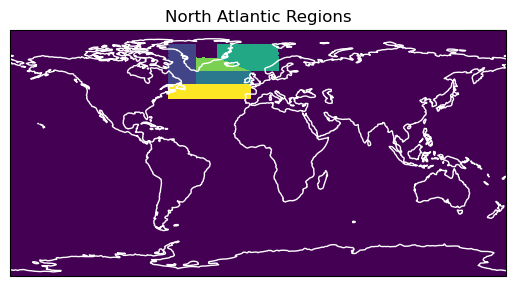

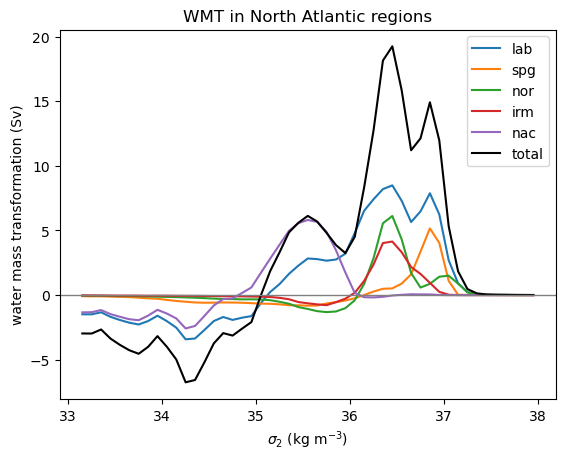

In [19]:
f=plt.figure()
ax=plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(tlon, tlat, ds_masked['regionmask'], transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.title('North Atlantic Regions')

f=plt.figure()
[plt.plot(wmt_spna.sigma2, wmt_timemean.sel(region=ii)/1e6, label = ds_masked['regionname'].sel(region=ii).values) \
     for ii in wmt_spna.region]
plt.plot(wmt_spna.sigma2, wmt_timemean.sum('region')/1e6, label = 'total', color='black')
plt.xlabel(r'$\sigma_{2}$ (kg m$^{-3}$)')
plt.ylabel('water mass transformation (Sv)')
plt.axhline(0,color='gray', linewidth=1)
plt.title('WMT in North Atlantic regions')
plt.legend();
